# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../../Data/NP/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,http_experiment_failure,x_dns_flags,status_code_match,resolver_asn,headers_match,blocking,body_length_match,input,control_failure,title_match,accessible,x_null_null_flags,x_blocking_flags,body_proportion,dns_consistency,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://fteproxy.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.sbc.net/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.ecequality.org/,NaN,True,True,NaN,NaN,1.000000,inconsistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.episcopalchurch.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.icrw.org/,NaN,True,True,NaN,NaN,0.999723,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,True,https://www.facebook.com/,NaN,NaN,True,NaN,NaN,0.975015,consistent,NaN
2022-12-31,AS23752,NaN,NaN,False,AS23752,True,False,NaN,https://www.instagram.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,NaN,https://www.youtube.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN


In [4]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'dns', 'http-diff', 'http-failure', nan, 'tcp_ip'],
      dtype=object)

## (2) Data Exploration

In [5]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [6]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

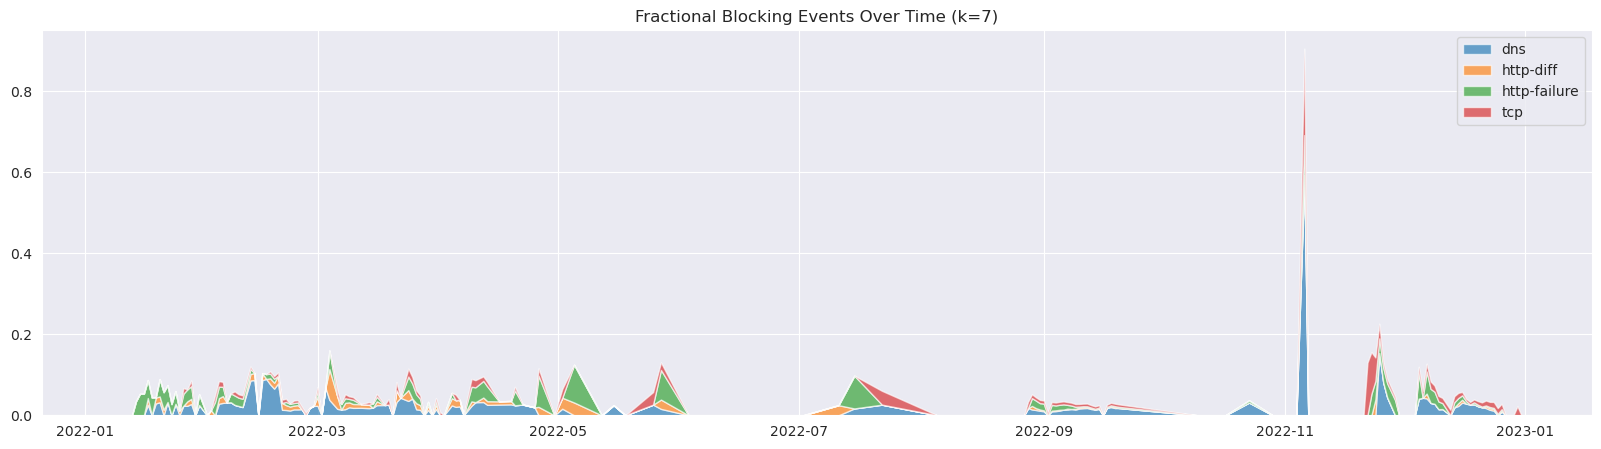

In [7]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-10-01-2022-12-01 (k=7)')

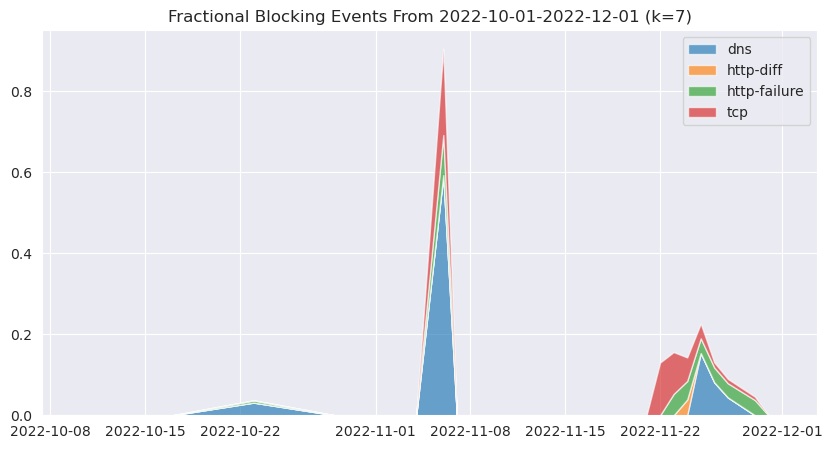

In [8]:
# Zoom in on a region of interest
start_date = '2022-10-01'
end_date = '2022-12-01'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [9]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn  \
input                                        date                   
http://128.31.0.39:9131/tor/server/authority 2022-03-06  AS140989   
                                             2022-03-24  AS140989   
                                             2022-03-26  AS140989   
                                             2022-03-31  AS140989   
                                             2022-11-06   AS23752   
...                                                           ...   
https://xhamster.com/                        2022-02-12   AS17501   
                                             2022-02-21  AS138388   
                                             2022-03-09   AS24550   
                                             2022-03-26  AS140989   
                                             2022-03-31  AS140989   

                                                        http_experiment_failure  \
input                                        date                                 
http://128.31.0.39:9131/tor/server/authority 2022-03-06   generic_timeout_error   
                                             2022-03-24   generic_timeout_error   
                                             2022-03-26   generic_timeout_error   
                                             2022-03-31   generic_timeout_error   
                                             2022-11-06      connection_refused   
...                                                                         ...   
https://xhamster.com/                        2022-02-12    ssl_invalid_hostname   
                                             2022-02-21    ssl_invalid_hostname   
                                             2022-03-09   generic_timeout_error   
                                             2022-03-26        host_unreachable   
                                             2022-03-31        host_unreachable   

                                                         x_dns_flags  \
input                                        date                      
http://128.31.0.39:9131/tor/server/authority 2022-03-06          NaN   
                                             2022-03-24          NaN   
                                             2022-03-26          NaN   
                                             2022-03-31          NaN   
                                             2022-11-06          NaN   
...                                                              ...   
https://xhamster.com/                        2022-02-12          NaN   
                                             2022-02-21          NaN   
                                             2022-03-09          NaN   
                                             2022-03-26          NaN   
                                             2022-03-31          NaN   

                                                        status_code_match  \
input                                        date                           
http://128.31.0.39:9131/tor/server/authority 2022-03-06               NaN   
                                             2022-03-24               NaN   
                                             2022-03-26               NaN   
                                             2022-03-31               NaN   
                                             2022-11-06               NaN   
...                                                                   ...   
https://xhamster.com/                        2022-02-12               NaN   
                                             2022-02-21               NaN   
                                             2022-03-09               NaN   
                                             2022-03-26               NaN   
                                             2022-03-31               NaN   

                                                        resolver_asn  \
input                                        date                  

In [10]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
https://www.planetromeo.com/                   67
http://194.109.206.212/tor/server/authority    67
http://gaytoday.com/                           52
https://www.pinkcupid.com/                     47
http://www.newnownext.com/                     46
                                               ..
https://www.theatlantic.com/                    1
https://www.state.gov/j/drl/                    1
http://astalavista.box.sk/                      1
http://amygoodloe.com/lesbian-dot-org/          1
http://advocacy.globalvoicesonline.org/         1
Length: 608, dtype: int64

In [11]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn http_experiment_failure  \
input                        date                                           
https://www.planetromeo.com/ 2022-01-14   AS17501               eof_error   
                             2022-01-23   AS17501               eof_error   
                             2022-02-09   AS17501               eof_error   
                             2022-02-17   AS17501               eof_error   
                             2022-02-18   AS17501               eof_error   
...                                           ...                     ...   
http://www.wetplace.com/     2022-03-31  AS140989                     NaN   
                             2022-04-12   AS17501               eof_error   
                             2022-12-16   AS17501                     NaN   
                             2022-12-16   AS17501                     NaN   
                             2022-12-16   AS17501                     NaN   

                                         x_dns_flags status_code_match  \
input                        date                                        
https://www.planetromeo.com/ 2022-01-14          NaN               NaN   
                             2022-01-23          NaN               NaN   
                             2022-02-09          NaN               NaN   
                             2022-02-17          NaN               NaN   
                             2022-02-18          NaN               NaN   
...                                              ...               ...   
http://www.wetplace.com/     2022-03-31          NaN             False   
                             2022-04-12          NaN               NaN   
                             2022-12-16          NaN             False   
                             2022-12-16          NaN             False   
                             2022-12-16          NaN             False   

                                        resolver_asn headers_match  \
input                        date                                    
https://www.planetromeo.com/ 2022-01-14      AS17501           NaN   
                             2022-01-23      AS17501           NaN   
                             2022-02-09      AS17501           NaN   
                             2022-02-17      AS17501           NaN   
                             2022-02-18      AS17501           NaN   
...                                              ...           ...   
http://www.wetplace.com/     2022-03-31     AS140989         False   
                             2022-04-12      AS17501           NaN   
                             2022-12-16      AS17501          True   
                             2022-12-16      AS17501          True   
                             2022-12-16      AS17501          True   

                                             blocking body_length_match  \
input                        date                                         
https://www.planetromeo.com/ 2022-01-14  http-failure               NaN   
                             2022-01-23  http-failure               NaN   
                             2022-02-09  http-failure               NaN   
                             2022-02-17  http-failure               NaN   
                             2022-02-18  http-failure               NaN   
...                                               ...               ...   
http://www.wetplace.com/     2022-03-31           dns             False   
                             2022-04-12  http-failure               NaN   
                             2022-12-16     http-diff             False   
                             2022-12-16           dns             False   
                             2022-12-16           dns             False   

                                        control_failure title_match  \
input                        date                                     
https://www.planetromeo.com/ 2022-01-14       